# Experiment 12 attention map visualization

In [1]:
import random

import torch
import matplotlib.pyplot as plt

from arithmetic_lm.model import TransformerDecoder, generate
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.interp import plot_attn_maps, plot_module
from arithmetic_lm.constants import PLOTS_DIR

import warnings

warnings.filterwarnings("ignore")

In [2]:
tokenizer = CharTokenizer()

In [3]:
def load_model(ckpt_path: str) -> tuple[torch.nn.Module, dict]:
    # load model
    ckpt = torch.load(ckpt_path, map_location="mps")
    model = TransformerDecoder(
        **ckpt["hyper_parameters"]["model_hparams"],
        # vocab_size=tokenizer.vocab_size,
    )
    # state dict has a prefix "model." in the key names
    model.load_state_dict({k[6:]: v for k, v in ckpt["state_dict"].items()})
    model.eval()
    return model, ckpt["hyper_parameters"]

In [4]:
# before and after phase transition
# ckpt_path_before = "../checkpoints/addition-high-n-digit-variation/trans_dec_2layers_384embd_3head/step500000-train_loss1.9965-val_loss1.9776_backup.ckpt"
# ckpt_path_after = "../checkpoints/addition-high-n-digit-variation/trans_dec_2layers_384embd_3head/step1054000-train_loss1.5561-val_loss1.5174.ckpt"
# ckpt_path_after = "../checkpoints/addition-high-n-digit-variation/trans_dec_2layers_384embd_3head/step1442000-train_loss1.5494-val_loss1.5165.ckpt"

ckpt_path_sin = "../checkpoints/addition-high-n-digit-variation/trans_dec_2layers_384embd_3head/step2500000-train_loss1.5547-val_loss1.5165.ckpt"
ckpt_path_abaacus = "../checkpoints/addition-high-n-digit-variation/trans_dec_2layers_384embd_3head_abacus/step84000-train_loss2.2793-val_loss2.2866.ckpt"

In [5]:
model_sin, hparams = load_model(ckpt_path_sin)
model_abacus, _ = load_model(ckpt_path_abaacus)

In [6]:
module_names = [
    "transformer_encoder.layers[0].self_attn",
    "transformer_encoder.layers[1].self_attn",
]
figsize = (14, 8)

In [7]:
subdir = PLOTS_DIR / "exp_12_abacus"
subdir.mkdir(exist_ok=True)

In [8]:
def eval_answer(model: torch.nn.Module, tokenizer, prompt: str, answer: str) -> bool:
    """Return whether the model predicts the correct answer."""

    prompt_tokens = torch.tensor(tokenizer.encode(prompt))
    stop_token_id = tokenizer.encode("$")[0]

    pred_ans = generate(
        model, idx=prompt_tokens, max_new_tokens=20, stop_token=stop_token_id
    )

    pred_ans = tokenizer.decode(pred_ans[0])
    pred_ans = pred_ans.strip("$")
    return pred_ans == answer

In [9]:
# # find failure cases
# while True:
#     a = random.randint(10**5, 10**6)
#     b = random.randint(10**5, 10**6)
#     prompt = f"${a}+{b}="
#     true_ans = str(a + b)
#     if not eval_answer(model_before, tokenizer, prompt, true_ans) and not eval_answer(
#         model_after, tokenizer, prompt, true_ans
#     ):
#         break

# print(f"prompt: {prompt}")

prompt: '$123456+678901=' 6+6
true_ans: 802357
DEBUG: module_name=transformer_encoder.layers[0].self_attn module=MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
) hook_dict={'hook': <function get_attention_map.<locals>.hook at 0x12faeeca0>, 'pre_hook': <function set_attn_kwargs_prehook at 0x12faec0e0>}
DEBUG: module_name=transformer_encoder.layers[1].self_attn module=MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
) hook_dict={'hook': <function get_attention_map.<locals>.hook at 0x12faeed40>, 'pre_hook': <function set_attn_kwargs_prehook at 0x12faec0e0>}
pred_answer: 802357$
transformer_encoder.layers[0].self_attn torch.Size([1, 3, 21, 21])
transformer_encoder.layers[1].self_attn torch.Size([1, 3, 21, 21])


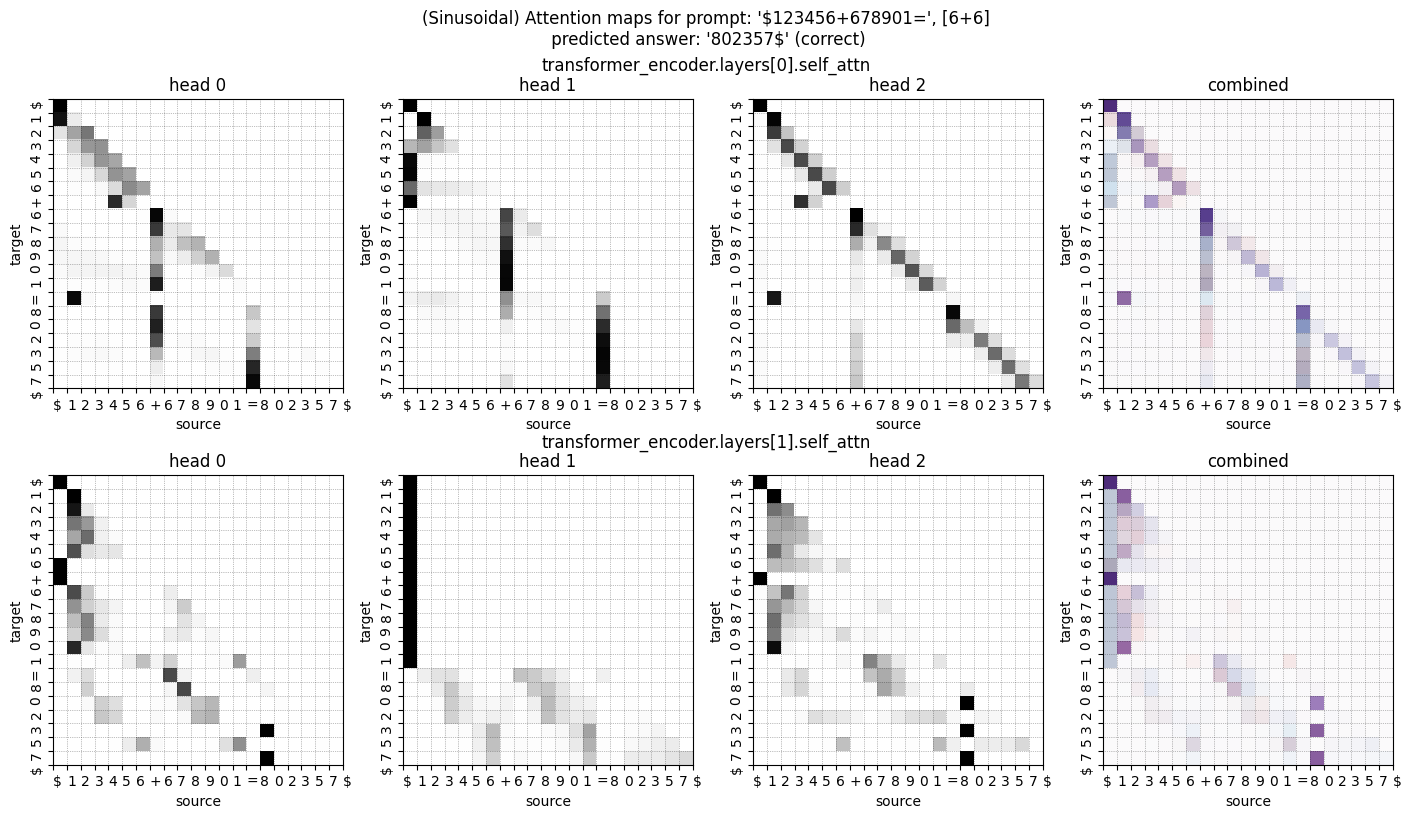

prompt: '$654321+109876=' 6+6
true_ans: 753208
DEBUG: module_name=transformer_encoder.layers[0].self_attn module=MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
) hook_dict={'hook': <function get_attention_map.<locals>.hook at 0x14c221f80>, 'pre_hook': <function set_attn_kwargs_prehook at 0x12faec0e0>}
DEBUG: module_name=transformer_encoder.layers[1].self_attn module=MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
) hook_dict={'hook': <function get_attention_map.<locals>.hook at 0x14c221e40>, 'pre_hook': <function set_attn_kwargs_prehook at 0x12faec0e0>}
pred_answer: 4444011$
transformer_encoder.layers[0].self_attn torch.Size([1, 3, 22, 22])
transformer_encoder.layers[1].self_attn torch.Size([1, 3, 22, 22])


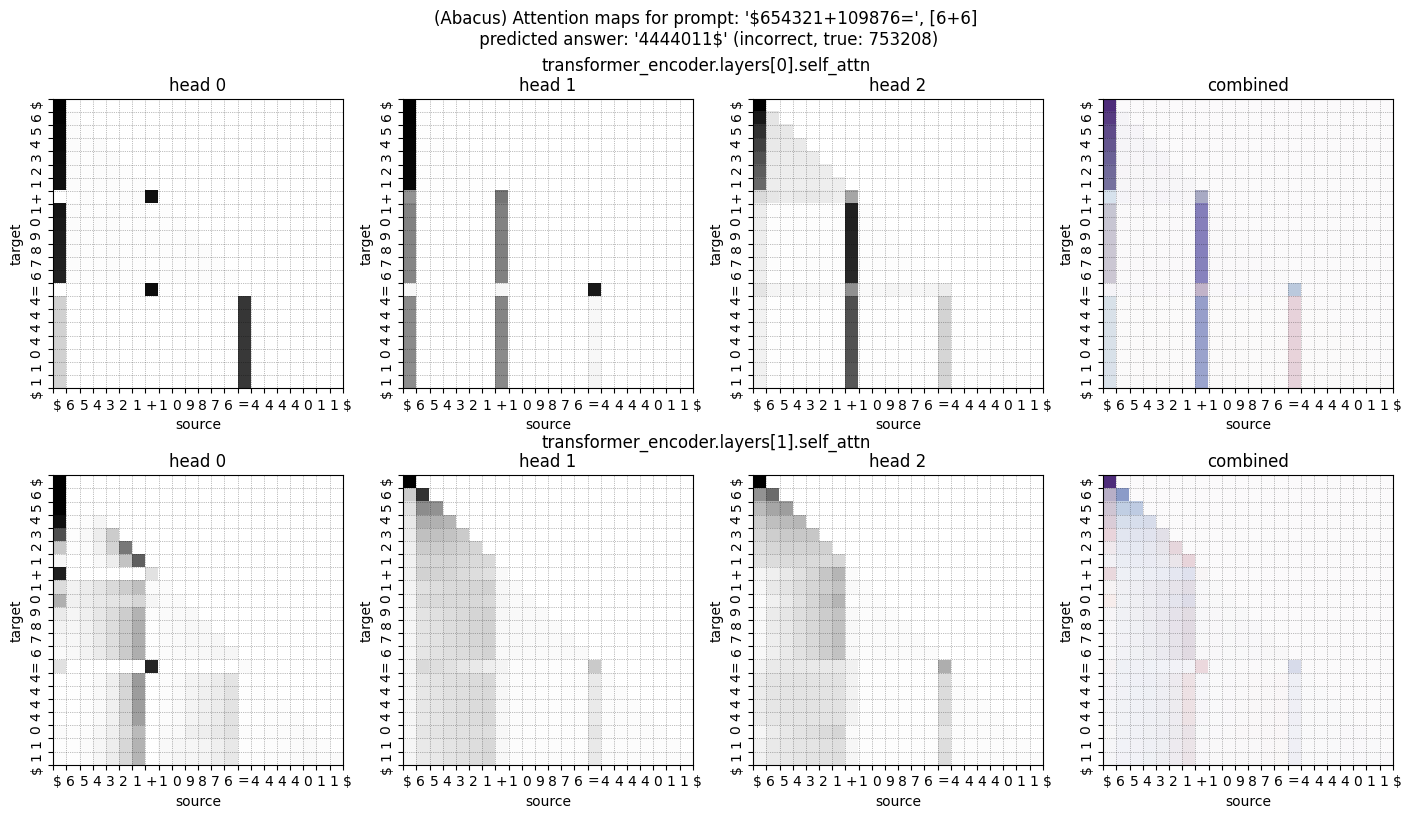

In [10]:
a, b = 123456, 678901
savepath = subdir / f"exp12_attention_maps_{a}+{b}.png"
kwargs = dict(
    tokenizer=tokenizer,
    a=a,
    b=b,
    module_names=module_names,
    figsize=figsize,
    # save=True,
)
plot_attn_maps(
    model=model_sin,
    savepath=str(savepath).replace(".png", "_sin.png"),
    figtitle_prefix="(Sinusoidal)",
    **kwargs,
)
attn_maps = plot_attn_maps(
    model=model_abacus,
    savepath=str(savepath).replace(".png", "_abacus.png"),
    figtitle_prefix="(Abacus)",
    reverse_ops=True,
    reverse_ans=True,
    **kwargs,
)